In this project, I'm going to explore the Kaggle baseball data set.  This file reads in the teams data from the sqlite database, does some data exploration and visualization, and finally I will do some unsupervised clustering to see if there's anything interesting there.

In [1]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

The data can be found in a sqlite database which I downloaded from the Kaggle datasets site.  I read the team table into a pandas DataFrame called teams.

In [2]:
conn = sqlite3.connect("/home/craig/Documents/ML_Projects/Kaggle/Baseball/database.db")
teams = pd.read_sql_query("SELECT * FROM team", conn)
teams = teams.loc[teams['year'] >= 1950]

I'm going to inspect the shape of the data, the data types of the columns, and then remove a couple of unnecessary identifier columns.  Some columns that should be numeric are not currently formatted as such, so I will need to cast those as well.

In [3]:
teams.shape  # 1622 x 48 columns
teams.dtypes

def removeColumns(data, ids=[]):
    try:
        new_data = data.drop(labels=ids, axis=1,inplace=False)
    except:
        print("Columns already removed")
    return new_data

# remove unwanted ID columns
teams = removeColumns(teams, ids=['team_id_lahman45', 'team_id_retro'])

# create new DataFrame that only contains numeric variables
cols = ['year','league_id','franchise_id','div_id','div_win','wc_win',
        'lg_win','ws_win','team_id_br','name','park','team_id','rank']
teams_num = removeColumns(teams, cols)


In [4]:
# Convert all remaining columns to numeric
teams_num = teams_num.apply(pd.to_numeric)
# teams_num.dtypes
teams_num.describe()

,g,ghome,w,l,r,ab,h,double,triple,hr,...,ha,hra,bba,soa,e,dp,fp,attendance,bpf,ppf
count,1622.000000,1622.000000,1622.000000,1622.000000,1622.000000,1622.000000,1622.000000,1622.000000,1622.000000,1622.000000,...,1622.000000,1622.000000,1622.000000,1622.000000,1622.000000,1622.000000,1622.000000,1.622000e+03,1622.000000,1622.000000
mean,158.991369,79.487053,79.407522,79.407522,700.036375,5420.927250,1403.971640,249.426017,34.726880,142.334155,...,1403.995068,142.334155,523.454377,933.592478,122.448212,149.462392,0.976628,1.823473e+06,100.203453,100.202836
std,9.558091,4.864685,12.548330,12.499713,98.014348,334.846959,118.440042,43.613853,10.870558,39.570433,...,121.086445,33.237289,75.161788,187.755024,25.348322,20.221952,0.006180,8.299794e+05,4.690472,4.794369
min,103.000000,44.000000,37.000000,40.000000,329.000000,3493.000000,797.000000,119.000000,11.000000,32.000000,...,827.000000,40.000000,268.000000,388.000000,54.000000,74.000000,0.960000,2.471310e+05,88.000000,88.000000
25%,161.000000,80.000000,71.000000,71.000000,640.000000,5409.000000,1351.000000,216.000000,27.000000,113.250000,...,1346.000000,119.000000,476.000000,802.250000,104.000000,136.000000,0.970000,1.143266e+06,97.000000,97.000000
50%,162.000000,81.000000,80.000000,79.000000,699.000000,5497.000000,1410.000000,250.000000,34.000000,140.000000,...,1411.000000,142.000000,522.000000,930.500000,122.000000,150.000000,0.980000,1.733647e+06,100.000000,100.000000
75%,162.000000,81.000000,89.000000,88.000000,761.750000,5565.750000,1476.000000,281.000000,41.000000,167.750000,...,1479.000000,165.000000,572.000000,1060.000000,139.000000,163.000000,0.981000,2.402519e+06,103.000000,103.000000
max,165.000000,84.000000,116.000000,120.000000,1027.000000,5781.000000,1684.000000,376.000000,79.000000,264.000000,...,1734.000000,241.000000,801.000000,1450.000000,210.000000,215.000000,0.991000,4.483350e+06,129.000000,129.000000


Next I'm going to create few variables based on basic baseball statistics that are generally thought to be indicative of team performance:  Slugging Percentage, On-base Percentage, and Walks+Hits per Inning Pitched.  The first two variables are often thought to be among the most important basic statistics for batters, while the third is an important pitching statistics.  I'm also going to create a separate singles variables, since doubles/triples/home runs are contained within the hits statistic, we can remove some of the relationship that we know to exist.  It will also make other statistics easier to calculate.

In [5]:
# First, we need to deal with NaN values in hbp and sf.  Let's impute NaNs to the mean value of the column.
# It's likely that these values were simply not tracked for earlier years, so we don't want to artificially
# devalue these stats for earlier years.
teams_num.isnull().sum()

teams_num['sf'].fillna(teams_num['sf'].mean(), inplace=True)
teams_num['hbp'].fillna(teams_num['hbp'].mean(), inplace=True)
teams_num['cs'].fillna(teams_num['cs'].mean(), inplace=True)

In [6]:
# Now we can create a singles column and games away column, as well as the more complicated stats mentioned above.
teams_num['single'] = teams_num['h'] - teams_num['double'] - teams_num['triple'] - teams_num['hr']
teams_num['gaway'] = teams_num['g'] - teams_num['ghome']
teams_num['obp'] = (teams_num['h'] + teams_num['bb'] + teams_num['hbp']) / (teams_num['ab'] + teams_num['bb'] + teams_num['hbp'] + teams_num['sf'])
teams_num['slg'] = (teams_num['single'] + teams_num['double']*2 + teams_num['triple']*3 + teams_num['hr']*4) / teams_num['ab']
teams_num['whip'] = (teams_num['bba'] + teams_num['ha']) / (teams_num['ipouts'] / 3)
teams_num['attendance'] = teams_num['attendance'] / 1000000 # units in millions

# remove columns that we've made better columns for
teams_num = removeColumns(teams_num, ['g', 'h'])

Next I want to check out any correlation among the variables using a correlation heatmap.  Since there are quite a few variables, it will be easier to see areas of concern than by look at correlation coefficients

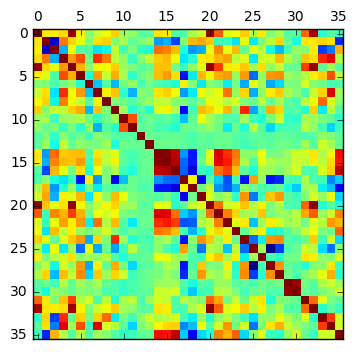

In [7]:
plt.matshow(teams_num.corr())
plt.show()

We can see some interesting correlation between variables 2 and 3, around 3-6, and around 14-18.
There are a few more pockets in the plot, but I'll inspect these for now, and just remain cognizant
that I might need to deal with multicollinearity at some point.

1.  Columns 2 and 3 are losses and runs.  These are negatively correlated.  This makes perfect sense, if a teams scores
    fewer runs, we'd expect them to win fewer games.
2.  Columns 3-6 are runs, at bats, doubles and triples.  These are all positively correlated - this makes sense
    that a team with more offensive productions would have more runs and more at bats.
3.  Columns 14-18 are runs against, earned runs allowed, earned run average, complete games pitched and shutouts pitched.
    The first three are all positively correlated and indicate poor pitching performance.  The last two are 
    negatively correlated with the first three, because they indicate good pitching performance.
    
Overall, the correlation we see in the data seems to make sense

In [8]:
teams_num[[2,3]] # losses and runs
teams_num[[3,4,5,6]] # runs, ab, double, triple
teams_num[[14,15,16,17,18]].head() # ra, er, era are all positively correlated, cg and sho are negatively correlated with those

,ra,er,era,cg,sho
1183,804,739,4.88,66,6
1184,724,661,4.28,62,10
1185,736,637,4.14,88,7
1186,749,669,4.41,62,7
1187,772,652,4.28,55,9


Next, I want to standardize these variables and then generate some clusters using a few different clustering methods.  This will help us identify similarities among teams in terms of their statistical performance.

In my first clustering attempt, I'm going to get the first two principal components so that we can easily visualize the clusters.  From there I will either cluster on the variables themselves or use additional principal components to get more precise clusters.


In [9]:
x = teams_num.values # returns numpy array of the data
standard_scaler = StandardScaler()
x_scaled = standard_scaler.fit_transform(x)
teams_num_sc = pd.DataFrame(x_scaled)

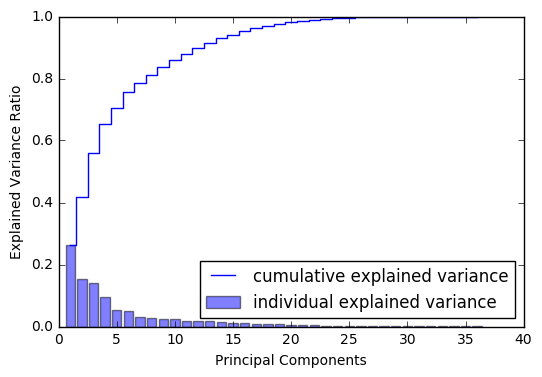

In [10]:
# Principal Components Function
def getPCAProjectionMatrix(dat, return_components=None):
    # Note: from Python ML, Raschka - custom code to expand from first 2 PCs to any number
    cov_mat = np.cov(dat.T)
    eigen_vals, eigen_vecs = np.linalg.eig(cov_mat)
    eigen_pairs = [(np.abs(eigen_vals[i]), eigen_vecs[:, i]) for i in range (len(eigen_vals))]
    eigen_pairs.sort(reverse=True)
    if not return_components:
        return_components = len(eigen_pairs)
    pairs=[]
    for i in range(return_components):
        pairs.append(eigen_pairs[i][1][:,np.newaxis])
    pairs=tuple(pairs)
    projection_matrix = np.hstack(pairs)
    transformed_data = dat.dot(projection_matrix)
    return transformed_data, projection_matrix, eigen_vals, eigen_vecs
    
def plotPCAVarianceExplained(eigen_vals):
    # Note: from Python Machine Learning, Raschka (awesome plot, thanks!)
    tot = sum(eigen_vals)
    var_exp = [(i / tot) for i in sorted(eigen_vals, reverse=True)]
    cum_var_exp = np.cumsum(var_exp)
    plt.bar(range(1, len(eigen_vals)+1), var_exp, alpha=0.5, align='center', label='individual explained variance')
    plt.step(range(1, len(eigen_vals)+1), cum_var_exp, where='mid', label='cumulative explained variance')
    plt.ylabel('Explained Variance Ratio')
    plt.xlabel('Principal Components')
    plt.legend(loc='best')
    plt.show()

# Get the PCA projection matrix to transform our data.  Get all PCs the first time for plotting.
_, _, eigen_vals, _ = getPCAProjectionMatrix(x_scaled)

# Plot the amount of variance explained by principal component
plotPCAVarianceExplained(eigen_vals)


In [11]:
# Get the first two PCs for clustering.  We can see above that the first 2 PCs account for a little more than 40%
# of the variation in the data.
x_scaled_pca, projection, eigen_vals, eigen_vecs = getPCAProjectionMatrix(x_scaled, 2)
x_scaled_pca.shape

(1622, 2)

Now that I have a two-dimensional data set, I'm going to do some clustering and plotting.

In [12]:
cluster = KMeans(n_clusters=4, init='random', max_iter=500, random_state=0)
x_cluster = cluster.fit_predict(x_scaled_pca)
x_cluster

array([3, 2, 2, ..., 3, 3, 3], dtype=int32)

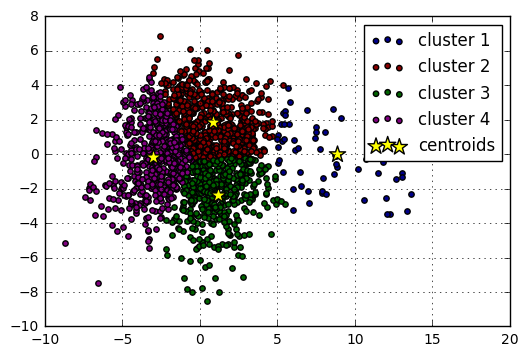

In [13]:
plt.scatter(x_scaled_pca[x_cluster==0,0],
            x_scaled_pca[x_cluster==0,1],
            s=15,
            c='darkblue',
            label='cluster 1')
plt.scatter(x_scaled_pca[x_cluster==1,0],
            x_scaled_pca[x_cluster==1,1],
            s=15,
            c='darkred',
            label='cluster 2')
plt.scatter(x_scaled_pca[x_cluster==2,0],
            x_scaled_pca[x_cluster==2,1],
            s=15,
            c='darkgreen',
            label='cluster 3')
plt.scatter(x_scaled_pca[x_cluster==3,0],
            x_scaled_pca[x_cluster==3,1],
            s=15,
            c='purple',
            label='cluster 4')
plt.scatter(cluster.cluster_centers_[:,0],
            cluster.cluster_centers_[:,1],
            s=150,
            marker='*',
            c='yellow',
            label='centroids')
plt.legend()
plt.grid()
plt.show()

We can see when we use four clusters we have:
1.  One cluster of teams that have very high values along the x-axis (cluster 1, blue)
2.  One cluster with low values along the x-axis (cluster 4, purple)
3.  One cluster with middle values on the x-axis and higher values along the y-axis (cluster 2, red)
4.  One cluster with middle values on the x-axis and lower values along the y-axis (cluster 3, green)

Without knowing anything about two principal components, I can't really describe the clusters at this point.  I'd need to either determine how the PCs vary with the actual variables, or describe each cluster based on the variables.  

Additionally, I chose four clusters kind of randomly.  In order to find a more optimal number of clusters, I'll want to run the K-means algorithm several times with different values for k.  I then can plot SSE against the number of clusters, and choose the value for K when the SSE starts to approximately level off (this is sometimes called the 'elbow plot', since a good choice for K is around the point where the plot forms an elbow shape).

I'll continue with these steps at a later time.